<a href="https://colab.research.google.com/github/Kedar154/Australia_Weather_Prediction/blob/main/%F0%9F%8C%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
%matplotlib inline

# Loading Data

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package')

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [ ]:
data0 = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
print(data0.head())
data0.dropna(subset = ['RainTomorrow'], inplace = True)

         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

# Cleaning & Splitting Data

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## Extracting year and month from date

In [ ]:
year = pd.to_datetime(data0['Date']).dt.year
months = pd.to_datetime(data0['Date']).dt.month
data = data0.drop(columns = ['Date'])
data['Month'] = months
data['Year'] = year
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12,2008
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12,2008


## Restructuring data to have numeric columns first followed by categorical columns

In [ ]:
num_cols = data.select_dtypes(include = np.number).drop(columns = ['Year']).columns
cat_cols = data.select_dtypes(exclude = np.number).columns
data = pd.concat([data['Year'],data[num_cols], data[cat_cols]], axis = 1)
cat_cols = cat_cols.drop(['RainTomorrow'])

## Splitting train test and validation data based on year

In [ ]:
train_df = data[data.Year < 2015]
train_df_inp = train_df.drop(columns = ['RainTomorrow', 'Year'])
train_df_out = train_df['RainTomorrow']

val_df = data[data.Year == 2015]
val_df_inp = val_df.drop(columns = ['RainTomorrow', 'Year'])
val_df_out = val_df['RainTomorrow']

test_df = data[data.Year > 2015]
test_df_inp = test_df.drop(columns = ['RainTomorrow', 'Year'])
test_df_out = test_df['RainTomorrow']

## Making a transformer pipeline to efficiently perform the imputation, scaling, onehotencoding

In [ ]:
num_TR = Pipeline( steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])
cat_TR = Pipeline( steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')),
])
TR = ColumnTransformer(transformers = [('num_TR', num_TR, slice(0,17)),
                                       ('cat_TR', cat_TR, slice(17,22))],
                       remainder='passthrough')

## Getting clean test, Train, validation data


In [ ]:
# Fit the ColumnTransformer only on the training input features
train_df_inp1 = TR.fit_transform(train_df_inp)
# Transform validation and test input features using the fitted transformer
val_df_inp1 = TR.transform(val_df_inp)
test_df_inp1 = TR.transform(test_df_inp)

# Map the target variables
train_df_out1 = train_df_out.map({'Yes': 1, 'No': 0})
val_df_out1 = val_df_out.map({'Yes': 1, 'No': 0})
test_df_out1 = test_df_out.map({'Yes': 1, 'No': 0})

# Decision Tree Classifier

## Training and Testing

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [ ]:
model.fit(train_df_inp1, train_df_out1)

DecisionTreeClassifier()

In [ ]:
model.score(train_df_inp1, train_df_out1)

0.9999696932961571

In [ ]:
model.score(val_df_inp1, val_df_out1)

0.7953107770878068

**🤮🤮🤮🤮🤮🤮**

In [ ]:
from sklearn.tree import plot_tree, export_text

In [ ]:
transformed_feature_names = TR.get_feature_names_out()

In [ ]:
plt.figure(figsize=(100,100))

plot_tree(model, feature_names = transformed_feature_names, max_depth = 3 ,filled=True)

[Text(0.5, 0.9, 'num_TR__Humidity3pm <= 0.97\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.7, 'num_TR__Humidity3pm <= -0.0\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.375, 0.8, 'True  '),
 Text(0.125, 0.5, 'num_TR__Sunshine <= -0.061\ngini = 0.146\nsamples = 48075\nvalue = [44251, 3824]'),
 Text(0.0625, 0.3, 'num_TR__Pressure3pm <= -0.268\ngini = 0.341\nsamples = 6260\nvalue = [4897, 1363]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'num_TR__WindGustSpeed <= 0.972\ngini = 0.111\nsamples = 41815\nvalue = [39354, 2461]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'num_TR__WindGustSpeed <= 0.669\ngini = 0.362\nsamples = 34343\nvalue = [26188, 8155]'),
 Text(0.3125, 0.3, 'num_TR__Rainfall <= 0.094\ngini = 0.308\nsamples = 28176\nvalue = [22809, 5367]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(

In [ ]:
importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.head(10))

                  Feature  Importance
9     num_TR__Humidity3pm    0.273129
5   num_TR__WindGustSpeed    0.063600
11    num_TR__Pressure3pm    0.059113
4        num_TR__Sunshine    0.047619
2        num_TR__Rainfall    0.041876
10    num_TR__Pressure9am    0.037056
8     num_TR__Humidity9am    0.036688
14        num_TR__Temp9am    0.036255
0         num_TR__MinTemp    0.034368
1         num_TR__MaxTemp    0.032671


## Regularisation

In [ ]:
print(model.tree_.max_depth)
model1 = DecisionTreeClassifier(max_depth=5)
model1.fit(train_df_inp1, train_df_out1)
model1.score(train_df_inp1, train_df_out1)
model1.score(val_df_inp1, val_df_out1)

49


0.8402878532876792

[Text(0.5, 0.9285714285714286, 'num_TR__Humidity3pm <= 0.97\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.7857142857142857, 'num_TR__Humidity3pm <= -0.0\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.375, 0.8571428571428572, 'True  '),
 Text(0.125, 0.6428571428571429, 'num_TR__Sunshine <= -0.061\ngini = 0.146\nsamples = 48075\nvalue = [44251, 3824]'),
 Text(0.0625, 0.5, 'num_TR__Pressure3pm <= -0.268\ngini = 0.341\nsamples = 6260\nvalue = [4897, 1363]'),
 Text(0.03125, 0.35714285714285715, 'num_TR__WindGustSpeed <= 0.972\ngini = 0.445\nsamples = 2763\nvalue = [1841, 922]'),
 Text(0.015625, 0.21428571428571427, 'num_TR__Humidity3pm <= -1.164\ngini = 0.395\nsamples = 1636\nvalue = [1193, 443]'),
 Text(0.0078125, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.0234375, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.046875, 0.21428571428571427, 'num_TR__Pressure3pm <= -1.304\ngini = 0.489\nsamples = 1127\nvalue = [648.0, 479.0]'),
 Text(0.039

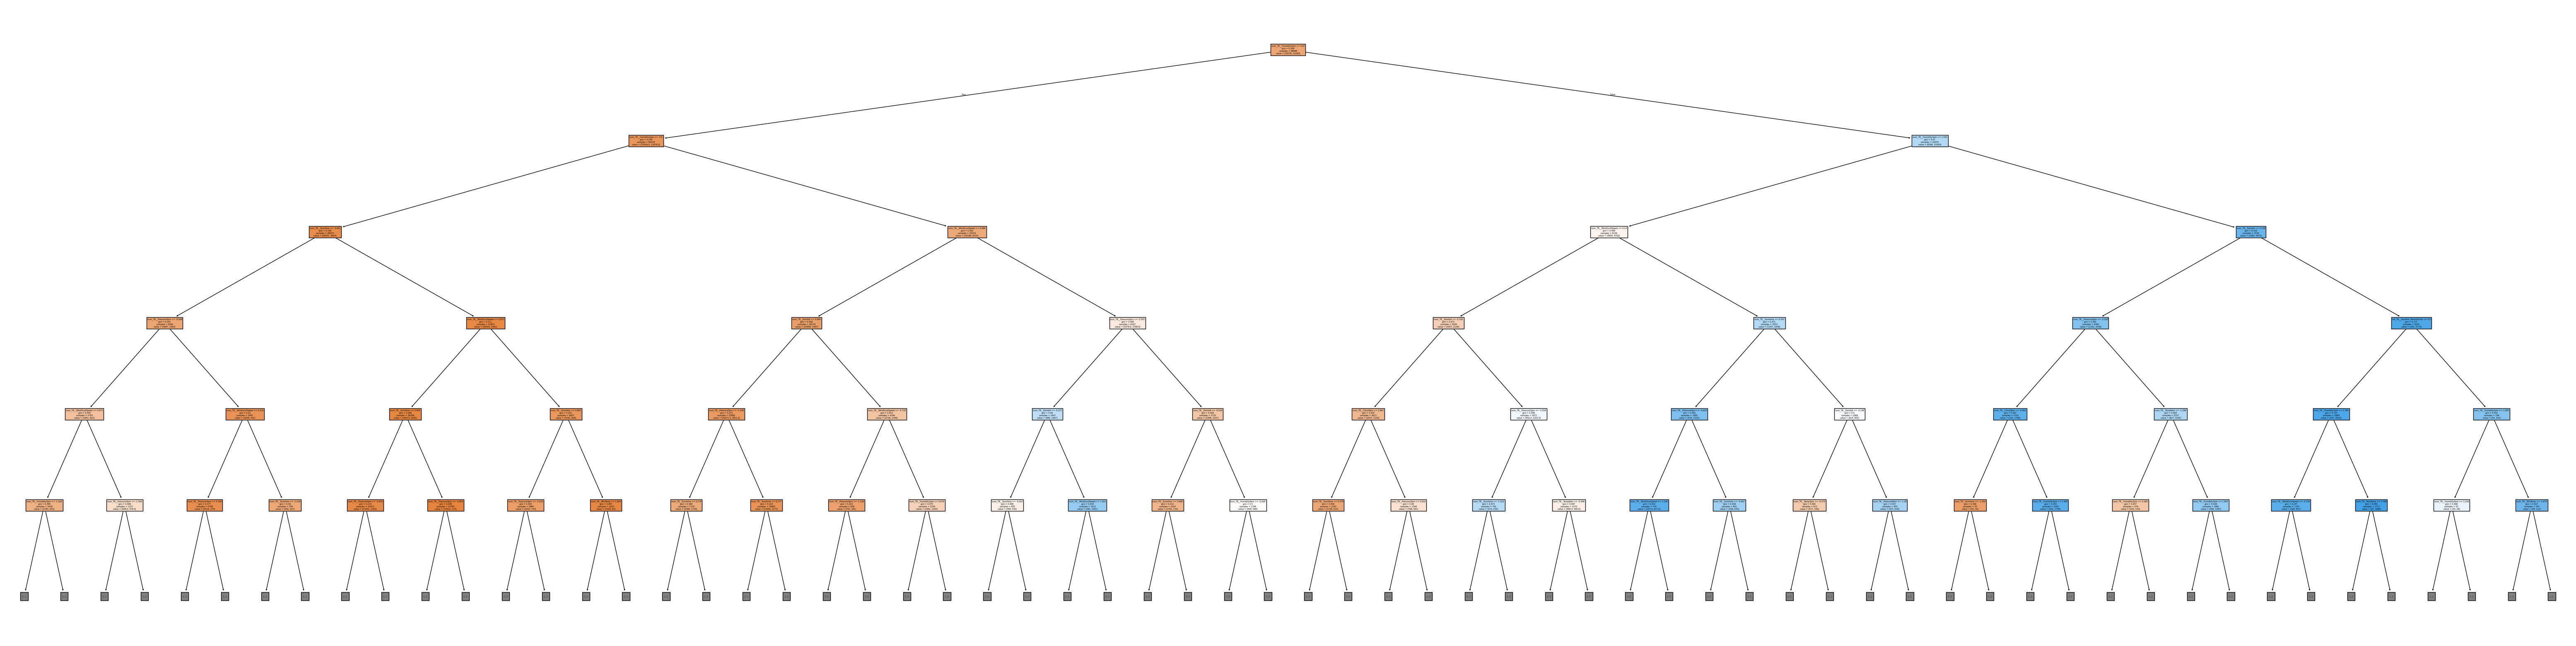

In [ ]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names = transformed_feature_names, max_depth = 5 ,filled=True)

### Finding Optimum Depth

In [ ]:
def depth( dmin, dmax, tinp = train_df_inp1, ttar = train_df_out1,vinp= val_df_inp1, vtar = val_df_out1):
  max_depth = []
  vacc = []
  tacc = []
  for i in range(dmin,dmax):
    model1 = DecisionTreeClassifier(max_depth=i)
    model1.fit(tinp, ttar)
    max_depth.append(i)
    vacc.append(model1.score(vinp, vtar))
    tacc.append(model1.score(tinp, ttar))
  return {'depth' : max_depth, 'Val_acc': vacc, 'Train_acc': tacc}

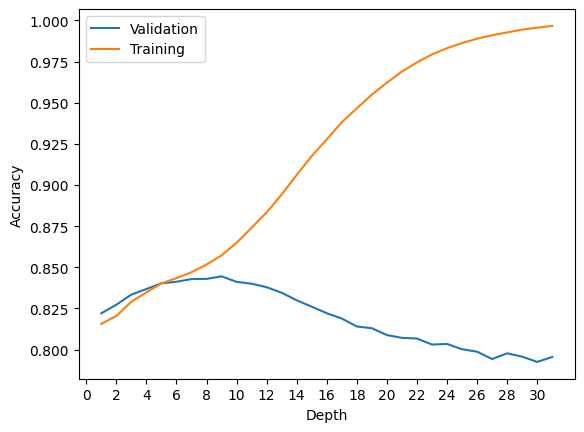

In [ ]:
depth_search = pd.DataFrame(depth(1,32))
plt.plot(depth_search['depth'], depth_search['Val_acc'])
plt.plot(depth_search['depth'], depth_search['Train_acc'])
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend(['Validation', 'Training'])
plt.xticks(range(0,32,2))
plt.show()

In [ ]:
print(depth(5,11))

{'depth': [5, 6, 7, 8, 9, 10], 'Val_acc': [0.8402878532876792, 0.8412164122801927, 0.8429574603911555, 0.8428413905170913, 0.8448145783761825, 0.8416806917764494], 'Train_acc': [0.8402028528710551, 0.8434759768860872, 0.8470016567664768, 0.8516789913928962, 0.8572756293692164, 0.8649028165030105]}


max acc at 9 depth

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_df_out1, model.predict(val_df_inp1), normalize = 'true')
print(cm)

[[0.95553265 0.04446735]
 [0.56743421 0.43256579]]


### Finding optimum Leaf Nodes

In [ ]:
def node( nmin, nmax,jump, tinp = train_df_inp1, ttar = train_df_out1,vinp= val_df_inp1, vtar = val_df_out1):
  node = []
  vacc = []
  tacc = []
  for i in range(nmin,nmax,jump):
    model1 = DecisionTreeClassifier(max_leaf_nodes=i, max_depth=9)
    model1.fit(tinp, ttar)
    node.append(i)
    vacc.append(model1.score(vinp, vtar))
    tacc.append(model1.score(tinp, ttar))
  return {'node' : node, 'Val_acc': vacc, 'Train_acc': tacc}

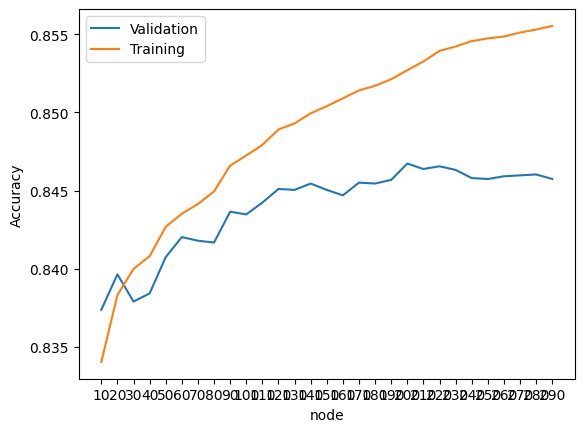

In [ ]:
min = 10
max = 300
node_search = pd.DataFrame(node(min,max,10))
plt.plot(node_search['node'], node_search['Val_acc'])
plt.plot(node_search['node'], node_search['Train_acc'])
plt.xlabel('node')
plt.ylabel('Accuracy')
plt.legend(['Validation', 'Training'])
plt.xticks(range(min,max,10))
plt.show()

In [ ]:
print(node(15,25,1))

{'node': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'Val_acc': [0.8368057570657536, 0.8368057570657536, 0.8368057570657536, 0.8381985955545238, 0.8396494689803261, 0.8396494689803261, 0.8396494689803261, 0.8397655388543903, 0.8383727003656201, 0.8383727003656201], 'Train_acc': [0.8347779528831778, 0.8347779528831778, 0.8347779528831778, 0.8372125914252233, 0.8383238372327959, 0.8383238372327959, 0.8383238372327959, 0.8388693579019679, 0.8395057986826686, 0.8395057986826686]}


max acc at 22 nodes

In [ ]:
model2 = DecisionTreeClassifier(max_leaf_nodes=22, max_depth=9)
model2.fit(train_df_inp1, train_df_out1)
print(model.score(val_df_inp1, val_df_out1))

0.8448145783761825


In [ ]:
cm = confusion_matrix(val_df_out1, model2.predict(val_df_inp1), normalize = 'true')
print(cm)

[[0.94956931 0.05043069]
 [0.56907895 0.43092105]]
